# SINDy-C Approach
This notebook imports control variables from the meteo station and tide gauge in order to try to implement SINDy with control into the program

In [36]:
# load packages
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
import random
import scipy
from scipy.integrate import odeint
from scipy.integrate import ode, complex_ode
from scipy.optimize import minimize
from findiff import FinDiff
import matplotlib.pyplot as plt
from time import perf_counter
from skimage import feature
from sklearn.metrics import r2_score
from tqdm import tqdm
from skimage.filters import meijering, sato, frangi, hessian
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from symfit import parameters, variables, sin, cos, Fit
import pickle
import math
from scipy.interpolate import UnivariateSpline
from PyAstronomy import pyaC
import get_temp_amplitude
import lmfit
from tg_solver import tg_solve
import pysindy as ps
from pysindy.feature_library import PolynomialLibrary, FourierLibrary
from pysindy.optimizers import STLSQ
from pysindy.feature_library import CustomLibrary
from DTS_to_displacement import DTS_to_disp, get_coefs

# import cv2

# matplotlib.use('TkAgg')
%matplotlib widget

# Set up data

In [37]:
# Read temperature data
infile = '../data/DTS/temp_cal_valid_cable_rmnoise.csv'
df_temp = pd.read_csv(infile, index_col=0)
df_temp.columns = pd.to_datetime(df_temp.columns)
df_temp.head()

,2023-08-09 17:09:32.415,2023-08-09 17:14:32.521,2023-08-09 17:19:32.622,2023-08-09 17:24:32.751,2023-08-09 17:29:32.871,2023-08-09 17:34:33.023,2023-08-09 17:39:33.151,2023-08-09 17:44:33.281,2023-08-09 17:49:33.393,2023-08-09 17:54:33.510,...,2023-08-29 13:21:53.278,2023-08-29 13:26:53.872,2023-08-29 13:31:54.456,2023-08-29 13:36:55.019,2023-08-29 13:41:55.583,2023-08-29 13:46:56.141,2023-08-29 13:51:56.718,2023-08-29 13:56:57.291,2023-08-29 14:01:57.900,2023-08-29 14:02:08.202
-22.999,21.8724,21.9242,21.7593,22.0574,22.2256,22.5217,22.7067,22.8808,23.2244,23.5173,...,25.5453,25.3991,25.4547,25.4546,25.6803,25.7883,25.9772,25.8514,25.8928,26.1549
-22.745,21.8849,21.9424,21.7415,22.0645,22.2294,22.5077,22.7098,22.8978,23.2494,23.5068,...,25.5339,25.4029,25.4845,25.4733,25.6727,25.8092,25.9818,25.8577,25.9044,26.1569
-22.490,21.8829,21.9581,21.7719,22.0786,22.2661,22.4844,22.7420,22.8877,23.2459,23.5008,...,25.5144,25.4283,25.4984,25.5012,25.6936,25.8112,25.9707,25.8581,25.9104,26.0933
-22.236,21.9095,21.9571,21.7812,22.0970,22.2612,22.4886,22.7592,22.8818,23.2265,23.4932,...,25.5312,25.4563,25.5038,25.5070,25.7078,25.7885,25.9619,25.8641,25.9341,26.1819
-21.982,21.9441,21.9227,21.7831,22.0871,22.2620,22.5016,22.7392,22.8826,23.2373,23.5235,...,25.5722,25.4460,25.5155,25.5173,25.7258,25.8020,25.9593,25.8840,25.9210,26.2319


In [38]:
# Read meteo data
infile = '../data/meteo/meteo_data.csv'
df_meteo = pd.read_csv(infile)
df_meteo['Time'] = pd.to_datetime(df_meteo['Time'])
df_meteo.head()

,Time,RH,Temp [C],Solar [W/m^2],Precipitated [mm],None,None.1
0,2022-07-23 13:20:00,0.372,12.8,9.2,2.4,NaN,NaN
1,2022-07-23 13:30:00,0.854,3.7,560.3,1.0,NaN,NaN
2,2022-07-23 14:00:00,0.855,4.1,701.3,0.0,NaN,NaN
3,2022-07-23 14:30:00,0.831,4.5,694.0,0.0,NaN,NaN
4,2022-07-23 15:00:00,0.820,5.1,761.7,0.0,NaN,NaN


In [39]:
# Read tide gauge data
infile = '../data/tidegauge/tidegauge_data.csv'
df_tide = pd.read_csv(infile)
df_tide['Time'] = pd.to_datetime(df_tide['Time'])
df_meteo.head()

,Time,RH,Temp [C],Solar [W/m^2],Precipitated [mm],None,None.1
0,2022-07-23 13:20:00,0.372,12.8,9.2,2.4,NaN,NaN
1,2022-07-23 13:30:00,0.854,3.7,560.3,1.0,NaN,NaN
2,2022-07-23 14:00:00,0.855,4.1,701.3,0.0,NaN,NaN
3,2022-07-23 14:30:00,0.831,4.5,694.0,0.0,NaN,NaN
4,2022-07-23 15:00:00,0.820,5.1,761.7,0.0,NaN,NaN


In [40]:
# Put temperature data, optical distances and sampling times into numpy arrays
temp_arr = df_temp.to_numpy().T # we want to have the time to be in the 0-axis to be consistent with DAS data
times = pd.to_datetime(df_temp.columns)
dists = df_temp.index.to_numpy()

In [41]:
# plot selected DTS data over time
# enter water at: 560m, exit water at 7565m
start_dist = 2820 # east ridge at 2820m optical distance
end_dist = 3150 # seafloor from ~3150m optical distance onward

start_time = datetime.datetime(2023,8,9)
end_time = datetime.datetime(2023,8,30)

t_idx_start = np.argmin(np.abs(times-start_time))
t_idx_end = np.argmin(np.abs(times-end_time))
d_idx_start = np.argmin(np.abs(dists-start_dist))
d_idx_end = np.argmin(np.abs(dists-end_dist))

plot_arr = temp_arr[t_idx_start:t_idx_end, d_idx_start:d_idx_end]
plot_times = times[t_idx_start:t_idx_end]
plot_dists = dists[d_idx_start:d_idx_end]


In [42]:
# Gaussian filter the data across the distance axes
filtered_arr = scipy.ndimage.gaussian_filter(plot_arr, 10, axes=1)

startt = start_time # datetime.datetime(2023, 8, 24, 16) # 25
endt = end_time # datetime.datetime(2023, 8, 26, 18) # 25
startind_t = np.absolute(plot_times - startt).argmin()
endind_t = np.absolute(plot_times - endt).argmin()

startind_d = np.absolute(plot_dists - 2900).argmin()
endind_d = np.absolute(plot_dists - 3300).argmin()

filtered_arr = scipy.ndimage.gaussian_filter(filtered_arr[startind_t:endind_t, startind_d:endind_d], 1.2)

plot_times_zoomed = plot_times[startind_t:endind_t]
plot_times_zoomed_int = plot_times_zoomed.astype('int64')
plot_dists_zoomed = plot_dists[startind_d:endind_d]

In [43]:
# Interpolating to fit meteorologic data and tide data to plot_times_zoomed
RH = np.interp(plot_times_zoomed, df_meteo['Time'], df_meteo['RH'])
air_temp = np.interp(plot_times_zoomed, df_meteo['Time'], df_meteo['Temp [C]'])
solar = np.interp(plot_times_zoomed, df_meteo['Time'], df_meteo['Solar [W/m^2]'])


tide_temp = np.interp(plot_times_zoomed, df_tide['Time'], df_tide['Temperature'])
air_pressure = np.interp(plot_times_zoomed, df_tide['Time'], df_tide['Pressure'])
sea_pressure = np.interp(plot_times_zoomed, df_tide['Time'], df_tide['Sea pressure'])
depth = np.interp(plot_times_zoomed, df_tide['Time'], df_tide['Depth'])
sos = scipy.signal.butter(10, 0.005, 'hp', fs=0.2, output='sos')
sea_pressure_hpass = scipy.signal.sosfilt(sos, sea_pressure - np.median(sea_pressure))

# Detecting the amplitude of the waves

## Convert DTS data to displacement

In [44]:
disps_interp, depths_interp = DTS_to_disp(200, filtered_arr, plot_times_zoomed, plot_dists_zoomed)

  0%|          | 0/200 [00:00<?, ?it/s]/Users/eric/Desktop/UW_Lab_Work/for_Eric/notebooks/DTS_to_displacement.py:61: RuntimeWarning: All-NaN slice encountered
  if(j < median_sub_window): avg_depth = np.nanmedian(contour_points_arr[i, 0:(j+median_sub_window)])
/Users/eric/Desktop/UW_Lab_Work/for_Eric/notebooks/DTS_to_displacement.py:63: RuntimeWarning: All-NaN slice encountered
  else: avg_depth = np.nanmedian(contour_points_arr[i, (j-median_sub_window):(j+median_sub_window)])
100%|██████████| 200/200 [00:16<00:00, 12.21it/s]


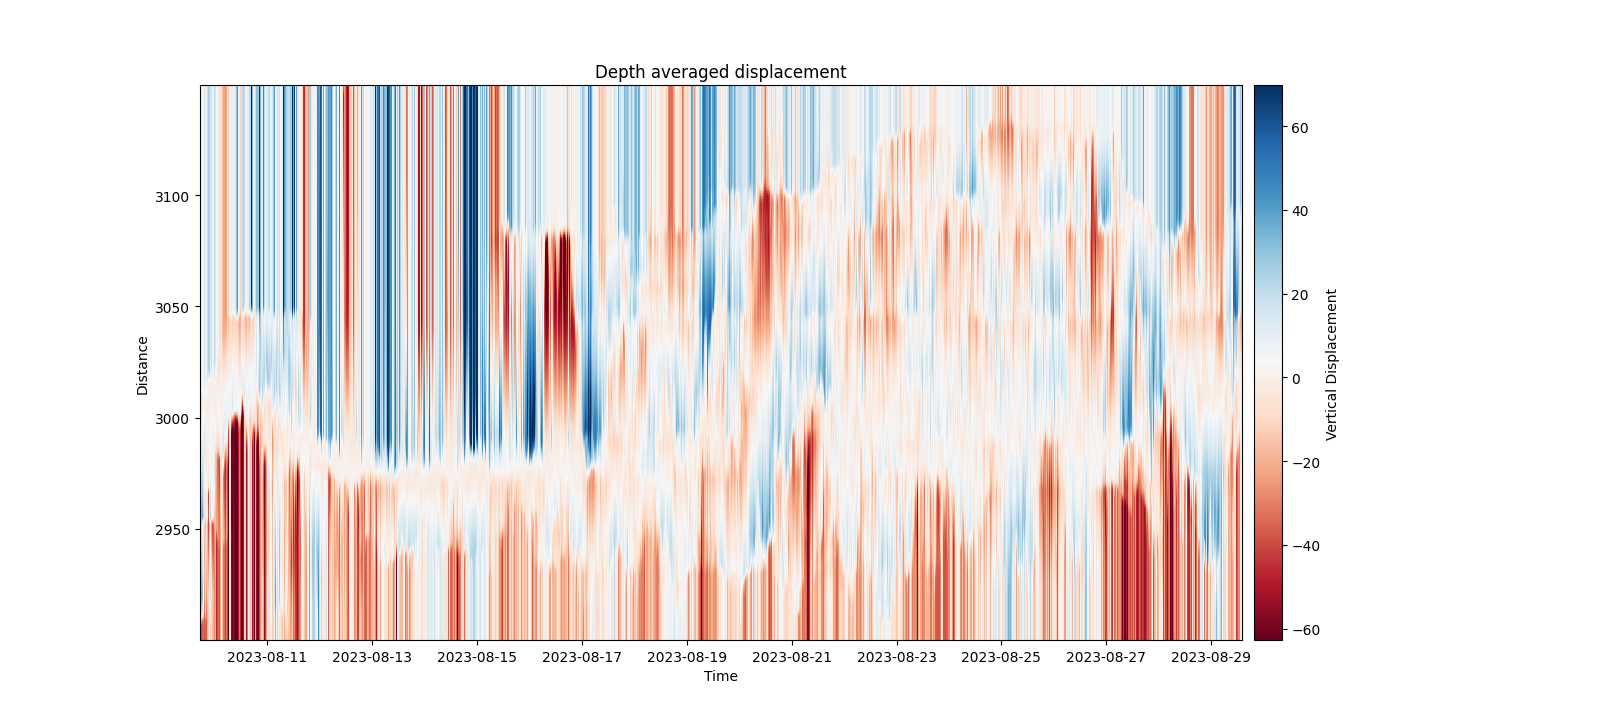

In [45]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
# for i in range(len(disps_interp[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + disps_interp[i, :])
ddt = np.gradient(disps_interp, axis=1)
im1 = ax.imshow(disps_interp, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='RdBu',
            vmin=np.percentile(disps_interp[~np.isnan(disps_interp)],1),
            vmax=np.percentile(disps_interp[~np.isnan(disps_interp)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
ax.set_title("Depth averaged displacement")

# plt.plot(times_flattened, depths_flattened, 'ok', label="input point", markersize=0.4)
# plt.scatter(X, Y, s=0.4)
plt.plot()
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement')
plt.show()


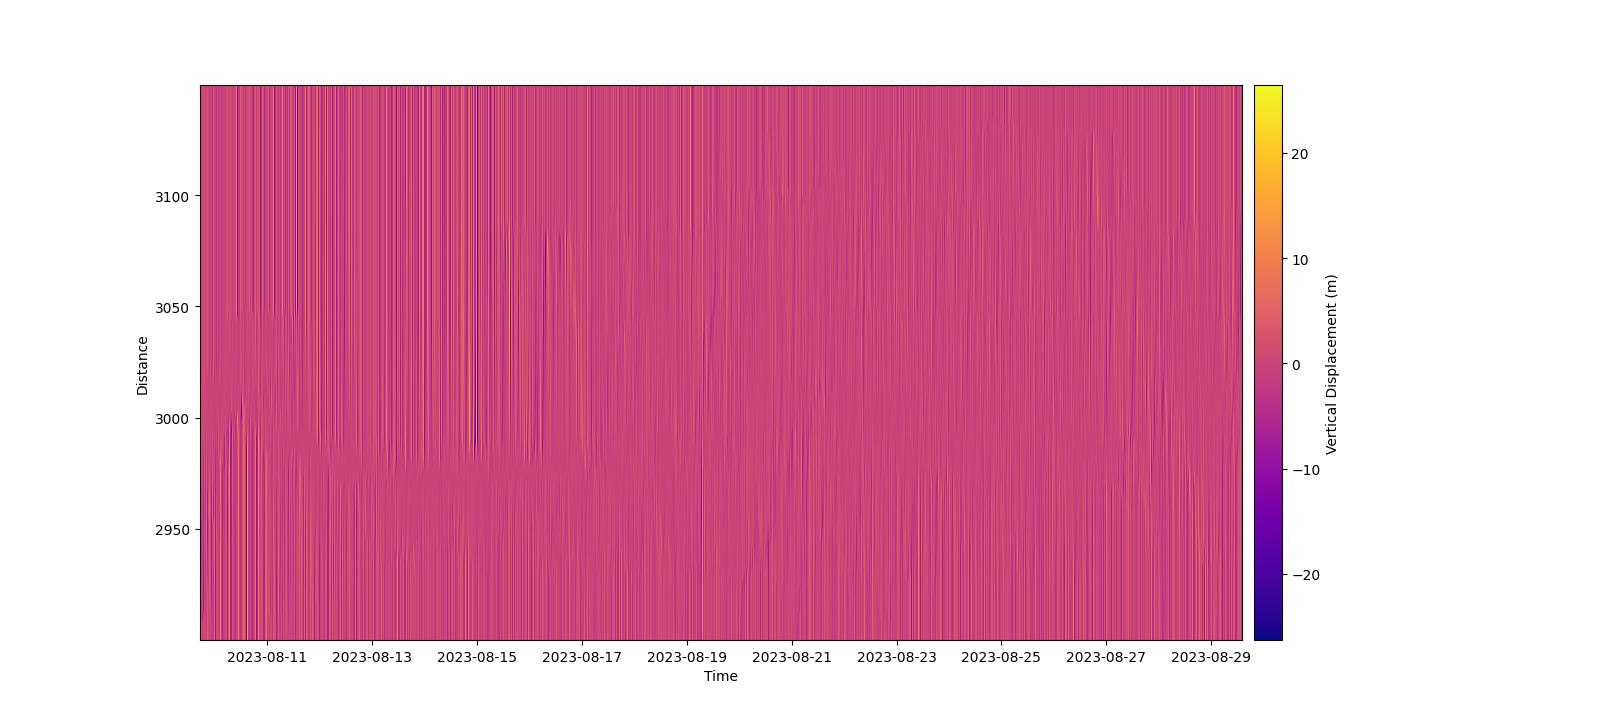

In [46]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
disps_interp = scipy.ndimage.gaussian_filter1d(disps_interp, 0.01) 
# for i in range(len(disps_interp[:, 0])): plt.plot(plot_times_zoomed, depths[i, :] + disps_interp[i, :])
ddt = np.gradient(disps_interp, axis=1)
ddtdt = np.gradient(ddt, axis=0)
im1 = ax.imshow(ddt, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(ddt[~np.isnan(ddt)],1),
            vmax=np.percentile(ddt[~np.isnan(ddt)],99),
            )
ax.set_ylabel('Distance') 
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Vertical Displacement (m)')
plt.show()


## Temperature plotted data

/var/folders/0w/3nhprhs523j29wbz2w1cnrl00000gn/T/ipykernel_37271/3879230885.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))


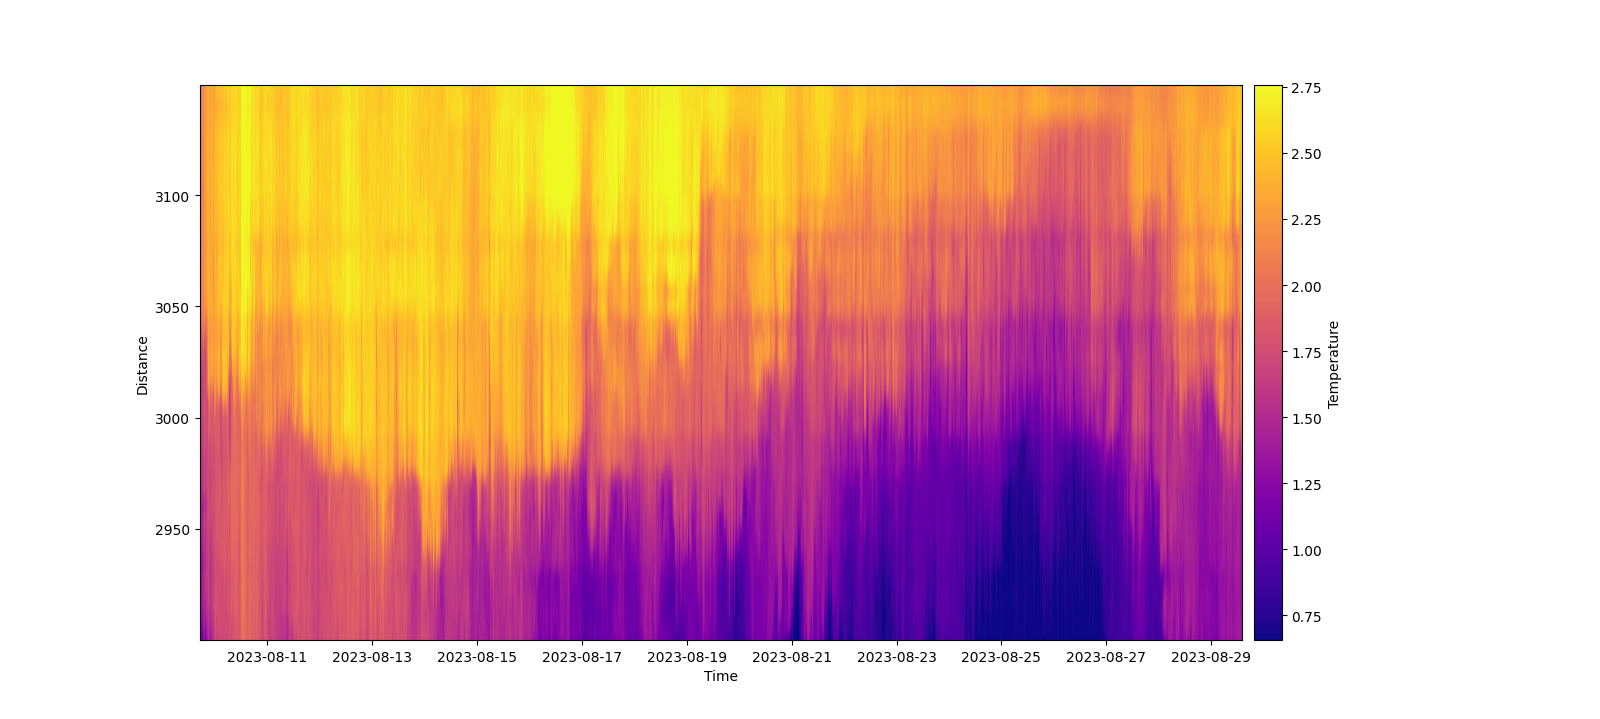

In [47]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
im1 = ax.imshow(filtered_arr.T, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='plasma',
            vmin=np.percentile(filtered_arr[~np.isnan(filtered_arr)],1),
            vmax=np.percentile(filtered_arr[~np.isnan(filtered_arr)],99),
            )
# for i in range(len(contour_values)): plt.plot(plot_times_zoomed, contour_points_arr[i], '-')
# for i in range(len(contour_values)): plt.plot(contour_points[contour_values[i]]['t'], contour_points[contour_values[i]]['x'], '.')
# plt.contour(plot_times_zoomed, plot_dists_zoomed, filtered_arr.T, contour_values)

ax.set_ylabel('Distance')
ax.set_xlabel('Time')
# plt.legend(contour_values_legend)

cbar = fig.colorbar(im1, pad=0.01)
cbar.set_label('Temperature')
plt.show()

# Set up SINDy

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps
# Seed the random number generators for reproducibility
np.random.seed(100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12
avg_temp = np.mean(filtered_arr, axis=1)

## SINDy Stuff

## Trying with original method with control (not weak)

In [49]:
def get_coefs(x, t, disps_interp, sparsity, control_vars, control_vars_names):
    # Set up x, t, and u variables
    dt = t[1] - t[0]
    dx = x[1] - x[0]
    
    u_sol = disps_interp
    v_sol = ps.SmoothedFiniteDifference(axis=1)._differentiate(u_sol, t=dt)
    
    # feature_value[:, 1] = ps.SmoothedFiniteDifference(axis=0)._differentiate(avg_temp, t=dt) 

    u = np.zeros((len(x), len(t), 2))
    u[:, :, 0] = u_sol
    u[:, :, 1] = v_sol
    u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)

    # Creating control variables array 
    control_vars_filled = np.zeros((len(x), len(t), len(control_vars_names)))
    for j in range(len(x)): control_vars_filled[j, :, :] = control_vars

    # Setting up function library
    library_functions = [
        lambda x: x,
        lambda x: x * x,
        lambda x, y: x * y
    ]
    library_function_names = [
        lambda x: x,
        lambda x: x + x,
        lambda x, y: x + y
    ]

    # Control variables function library
    parameter_lib = ps.PolynomialLibrary(degree=1, include_bias=False)
    
    # u and u' function libraray
    pde_lib = ps.PDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=2,
        spatial_grid=x,
        include_bias=False,
        is_uniform=True,
        periodic=True
    )

    lib = ps.ParameterizedLibrary(
        feature_library=pde_lib,
        parameter_library=parameter_lib,
        num_features=2,
        num_parameters=len(control_vars_names)
    )

    optimizer = ps.STLSQ(
        threshold=sparsity, # 8e-2
        max_iter=10000,
        normalize_columns=True,
    )
    
    # Set up model and fit the model
    feat_names = ['u', '(du/dt)']
    feat_names.extend(control_vars_names)
    
    model = ps.SINDy(feature_library=lib, feature_names=feat_names, optimizer=optimizer)

    try: model.fit(u, x_dot=u_dot, u=control_vars_filled, quiet=True)
    except: return model.get_feature_names(), np.zeros(len(model.get_feature_names())), 0

    # Get the coefficients
    coefficients = model.coefficients()

    # Get the term names
    feature_names = model.get_feature_names()
    score = model.score(u,t=dt, u=control_vars_filled)

    return feature_names, coefficients[1, :], score

In [50]:
t = np.array(plot_times_zoomed_int - plot_times_zoomed_int[0]) * 1.666e-11 # grid_x[:, 0]
x = depths_interp - depths_interp[0] # grid_y[0, :]

# Adding control variables and control variable names to lists:
control_labels = ['T_avg', 'F', 'P']
control_values = np.empty((len(t), len(control_labels)))
control_values[:, 0] = (avg_temp - np.min(avg_temp)) / (np.max(avg_temp) - np.min(avg_temp))
# control_values[:, 1] = (air_temp - np.min(air_temp)) / (np.max(air_temp) - np.min(air_temp))
# control_values[:, 2] = (RH - np.min(RH)) / (np.max(RH) - np.min(RH))
control_values[:, 1] = (solar - np.min(solar)) / (np.max(solar) - np.min(solar))
control_values[:, 2] = (sea_pressure_hpass - np.min(sea_pressure_hpass)) / (np.max(sea_pressure_hpass) - np.min(sea_pressure_hpass))
# control_values[:, 5] = (air_pressure - np.min(air_pressure)) / (np.max(air_pressure) - np.min(air_pressure))
# control_values[:, 6] = (depth - np.min(depth)) / (np.max(depth) - np.min(depth))
# control_values[:, 6] = (tide_temp - np.min(tide_temp)) / (np.max(tide_temp) - np.min(tide_temp))


['T_avg u', 'T_avg (du/dt)', 'T_avg uu', 'T_avg (du/dt)(du/dt)', 'T_avg u(du/dt)', 'T_avg u_1', 'T_avg (du/dt)_1', 'T_avg u_11', 'T_avg (du/dt)_11', 'T_avg uu_1', 'T_avg u(du/dt)_1', 'T_avg (du/dt)u_1', 'T_avg (du/dt)(du/dt)_1', 'T_avg uuu_1', 'T_avg uu(du/dt)_1', 'T_avg (du/dt)(du/dt)u_1', 'T_avg (du/dt)(du/dt)(du/dt)_1', 'T_avg u(du/dt)u_1', 'T_avg u(du/dt)(du/dt)_1', 'T_avg uu_11', 'T_avg u(du/dt)_11', 'T_avg (du/dt)u_11', 'T_avg (du/dt)(du/dt)_11', 'T_avg uuu_11', 'T_avg uu(du/dt)_11', 'T_avg (du/dt)(du/dt)u_11', 'T_avg (du/dt)(du/dt)(du/dt)_11', 'T_avg u(du/dt)u_11', 'T_avg u(du/dt)(du/dt)_11', 'F u', 'F (du/dt)', 'F uu', 'F (du/dt)(du/dt)', 'F u(du/dt)', 'F u_1', 'F (du/dt)_1', 'F u_11', 'F (du/dt)_11', 'F uu_1', 'F u(du/dt)_1', 'F (du/dt)u_1', 'F (du/dt)(du/dt)_1', 'F uuu_1', 'F uu(du/dt)_1', 'F (du/dt)(du/dt)u_1', 'F (du/dt)(du/dt)(du/dt)_1', 'F u(du/dt)u_1', 'F u(du/dt)(du/dt)_1', 'F uu_11', 'F u(du/dt)_11', 'F (du/dt)u_11', 'F (du/dt)(du/dt)_11', 'F uuu_11', 'F uu(du/dt)_11',

100%|██████████| 56/56 [00:42<00:00,  1.33it/s]


In [ ]:
# Running sindy on windows to get a time series evolution

window_size = 300
step_size = 100 # 20
n_segments = int(len(t)/step_size) - 1

feature_names, temp, score = get_coefs(x, t[0:100], disps_interp[:, 0:100], 4e-2, control_values[0:100, :], control_labels[:])
coefficients = np.empty((len(temp), n_segments))
segment_t = [0] * n_segments
sparsity = 2
scores = np.empty(n_segments)
print(feature_names)



for i in tqdm(range(n_segments)):
    start_t_ind = i*step_size# int(i * (len(t)/(n_segments)))
    end_t_ind = i*step_size + window_size # int((i+1) * (len(t)/(n_segments)))
    if(end_t_ind > len(t) - 1): end_t_ind = len(t) - 1
    segment_t[i] = plot_times_zoomed[int((start_t_ind + end_t_ind)/2)]
    feature_names, coefficients[:, i], score = get_coefs(x, t[start_t_ind:end_t_ind], disps_interp[:, start_t_ind:end_t_ind], sparsity, control_values[start_t_ind:end_t_ind], control_labels)
    scores[i] = score

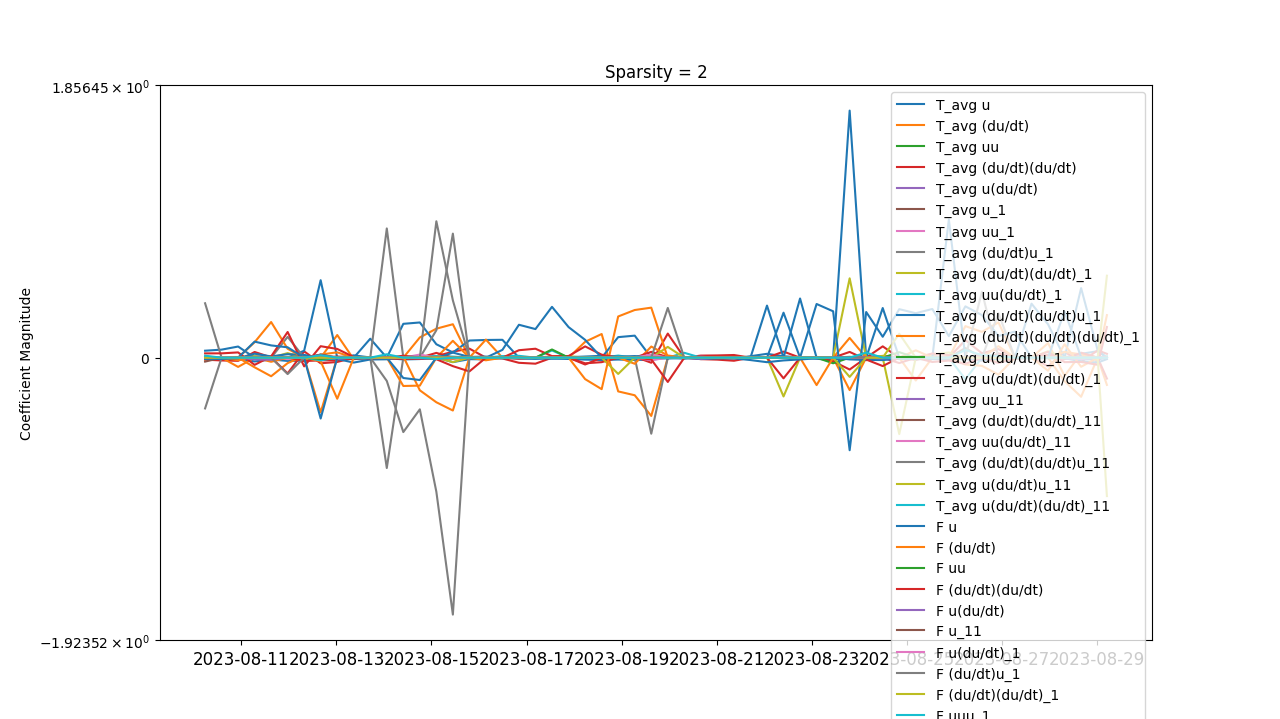

In [51]:
fig, ax = plt.subplots(figsize=(2*6.4,1.5*4.8))
for i in range(len(feature_names)): 
    if(np.mean(np.abs(coefficients[i, :])) > 0): plt.plot(segment_t, scipy.ndimage.gaussian_filter1d(coefficients[i, :], 0.1), '-', label=feature_names[i])
# i = 1
# plt.plot(segment_t, np.abs(coefficients[i, :]), '-', label=feature_names[i])
plt.title("Sparsity = " + str(sparsity))
plt.xticks(fontsize=12)
# plt.xlim(segment_t[0], segment_t[-1])
plt.yscale('symlog')
plt.ylabel('Coefficient Magnitude')
# plt.ylim([-1e-1, 1e-1])
plt.legend()

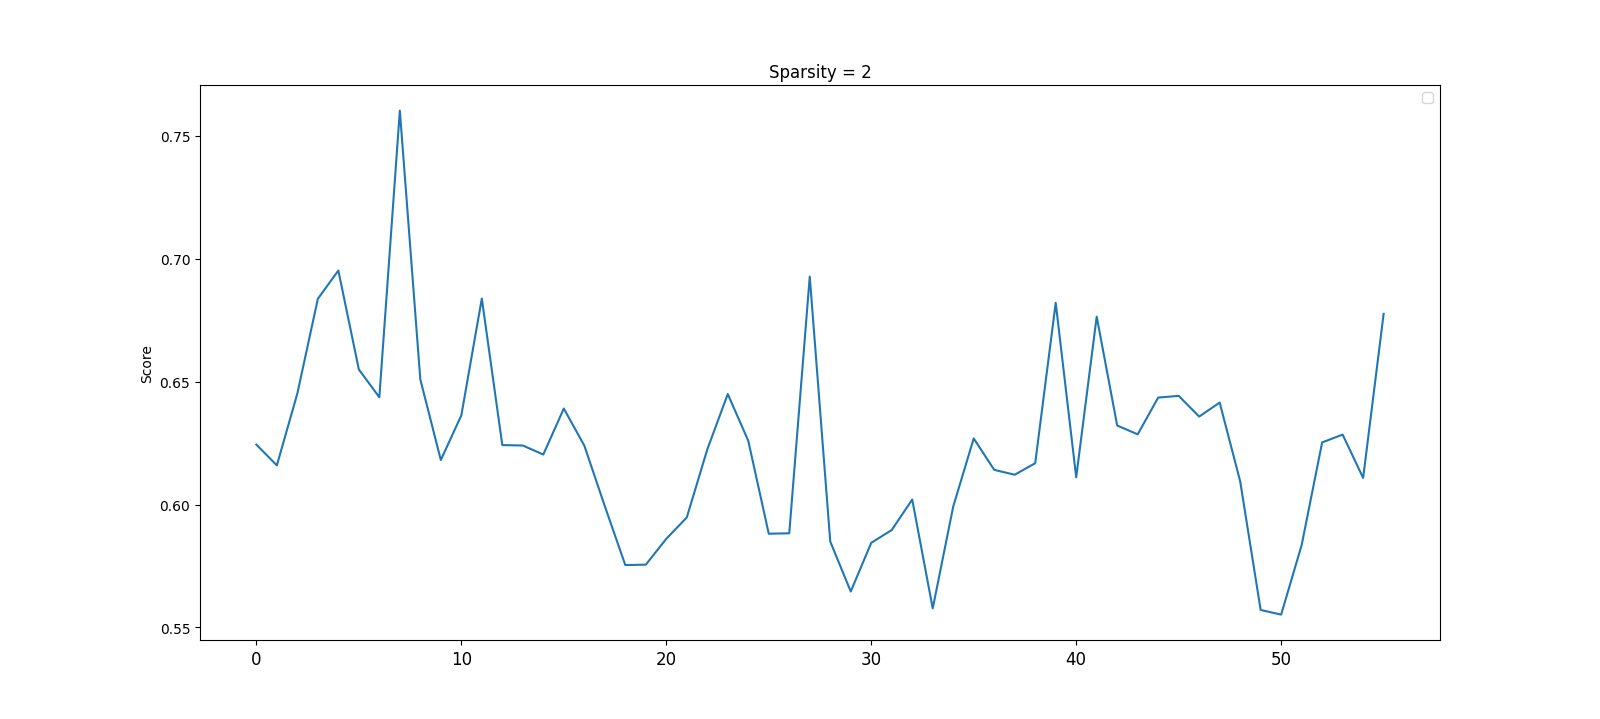

In [52]:
fig, ax = plt.subplots(figsize=(2.5*6.4,1.5*4.8))
plt.plot(scores)
# i = 1
# plt.plot(segment_t, np.abs(coefficients[i, :]), '-', label=feature_names[i])
plt.title("Sparsity = " + str(sparsity))
plt.xticks(fontsize=12)
# plt.xlim(segment_t[0], segment_t[-1])
# plt.ylim([-1e-1, 1e-1])
plt.ylabel("Score")
plt.legend()

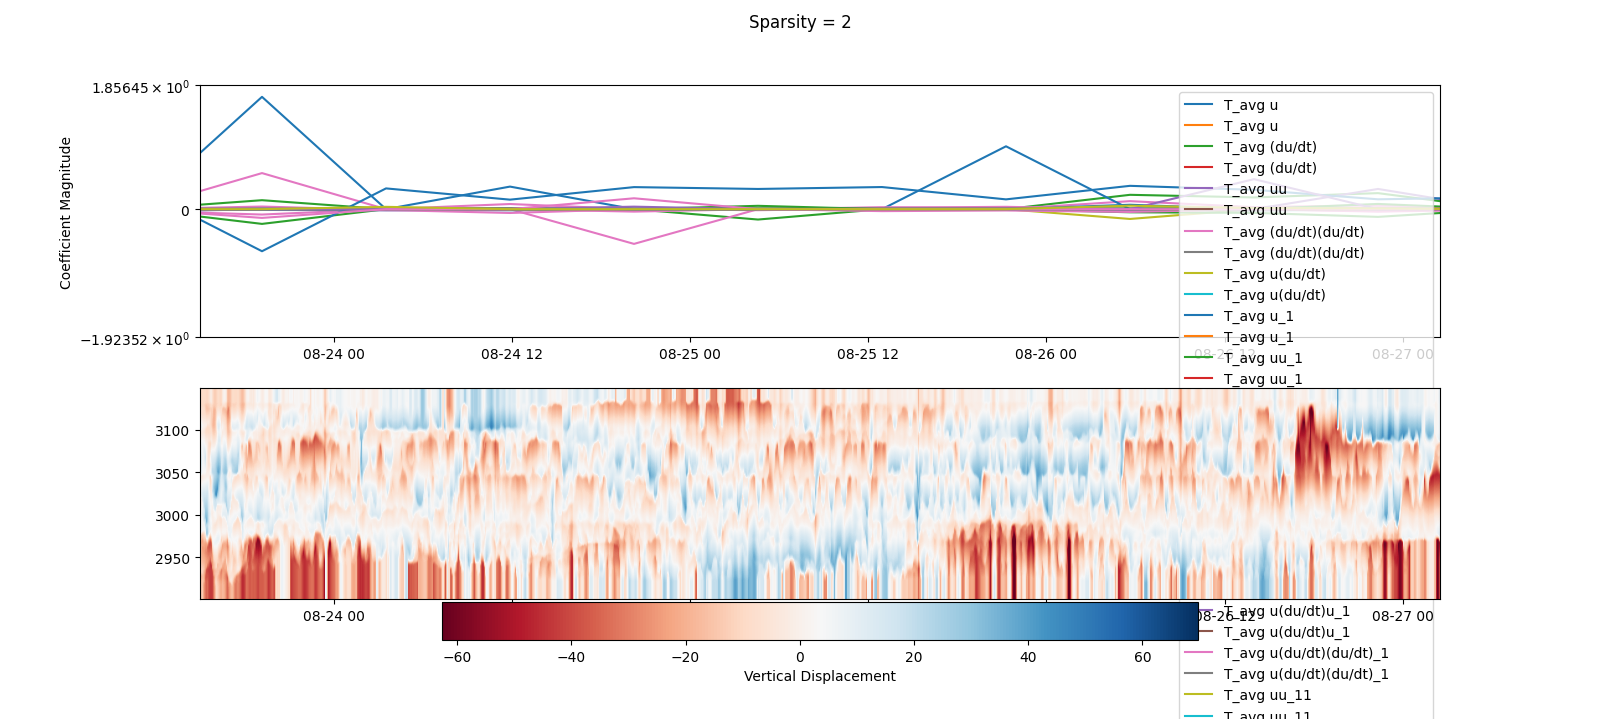

In [53]:
# Plotting a smaller segment of data to assess performance 

fig, ax = plt.subplots(2, figsize=(2.5*6.4,1.5*4.8))
for i in range(len(feature_names)): 
    if(np.mean(np.abs(coefficients[i, :])) > 0): ax[0].plot(segment_t, coefficients[i, :], 0.1, '-', label=feature_names[i])

# i = 1
# plt.plot(segment_t, np.abs(coefficients[i, :]), '-', label=feature_names[i])
fig.suptitle("Sparsity = " + str(sparsity))
# plt.xlim(segment_t[0], segment_t[-1])
ax[0].set_yscale('symlog')
ax[0].set_ylabel('Coefficient Magnitude')
ax[0].set_xlim([plot_times_zoomed[4000], plot_times_zoomed[5000]])
ax[1].set_xlim([plot_times_zoomed[4000], plot_times_zoomed[5000]])
ax[0].legend()

im1 = ax[1].imshow(disps_interp, origin='lower',
           aspect='auto',
            extent=[plot_times_zoomed[0], plot_times_zoomed[-1],
                   plot_dists_zoomed[0], plot_dists_zoomed[-1]],
            cmap='RdBu',
            vmin=np.percentile(disps_interp[~np.isnan(disps_interp)],1),
            vmax=np.percentile(disps_interp[~np.isnan(disps_interp)],99),
            )
cbar = fig.colorbar(im1, pad=0.01, orientation='horizontal')
cbar.set_label('Vertical Displacement')
# ax[1].vlines(plot_times_zoomed[np.arange(0, n_segments) * window_size], plot_dists_zoomed[0], plot_dists_zoomed[-1])